# Neural networks and gradient calculations with Pytorch

# Introduction

The latest Reinforcement Learning assignment involves some basic neural networks and gradient computations. Pytorch, an open-source machine learning framework, offers a bunch of features to construct, train and deploy neural networks as well as calculate derivatives, etc. This tutorial aims to offer you some basic background of neural networks and gradient calculations to help to start your assignment. This tutorial includes two parts. In the first part, we cover the basic linear regression model and neural network and you can skip this part if you have prior knowledge. In the second part, we talk about how to stop gradient. This operator is used when implementing the DQN algorithm. So please make sure you understand this operator before Exercise 4.

If you are interested in diving into the Pytorch and deep learning, please check these excellent materials. 

1. Pytorch Tutorial: https://pytorch.org/tutorials/

2. Dive into Deep Learing: https://d2l.ai/

3. Deep Learning course: CS-E4890, Aalto; CS231N, Stanford http://cs231n.stanford.edu/

In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Part I
## 1. Let's start with linear regression
Suppose we have a bunch of data points generated from a linear model $y_i = wx_i + b$ with additive noise. Our task is to decide the linear model's weight $w$ and bias $b$ using these data on hand.

In [2]:
# generate synthetic data
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.5, y.shape)  # additive noise
    return X, y.reshape((-1, 1))

true_w = torch.tensor([-3.4])
true_b = torch.tensor([4.2])

# generate data
features, labels = synthetic_data(true_w, true_b, 1000) # generate 1000 data points

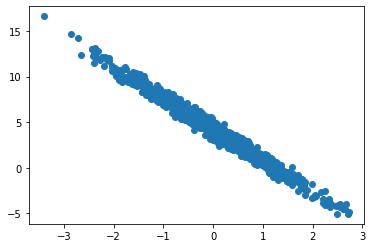

In [3]:
# plot data
plt.scatter(features, labels)

In [4]:
# process the training data
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

### Initialize model parameters and define the model
To learn a model from data points, let's first define the model form as $y = wx + b$ and initialize our model.

In [5]:
w = torch.normal(mean=torch.tensor([0.0]), std=torch.tensor([0.1]))
b = torch.zeros(1)
print(f'The initial weight is: {w}, the intial bias is {b}')

The initial weight is: tensor([-0.0432]), the intial bias is tensor([0.])


However, this is not enough! If we want to calculate the gradient w.r.t $w$ and $b$, we have to define it explicitly by setting `requires_grad=True`. This is important, otherwise, we can't optimize these parameters by the optimizer. In practice, you should always take care of which parameter should be set `requires_grad` as `True` and when to set them. Also, in some cases, we need to set `requires_grad` as `False`, and we will discuss it in Part 2.

In [6]:
w.requires_grad = True
b.requires_grad = True
print(f'After set requires_grad=Ture, the w is: {w}, and b is {b}')

After set requires_grad=Ture, the w is: tensor([-0.0432], requires_grad=True), and b is tensor([0.], requires_grad=True)


In [7]:
def model(x, w, b):
    """ Define the linear regression model."""
    return w * x + b

### Define the loss function and define the optimization algorithm
The optimization objective we used here is the **mean square error**: $L = \frac{1}{N} \sum_{i=1}^N \frac{1}{2}(y_i - \hat{y_i})^2$

In [8]:
def loss_fn(y_hat, y):
    return (y - y_hat)**2 * 0.5

Once we define the model and the loss function, there are many methods to define the parameters $w$ and $b$ to minimize the loss function. For example, we can calculate the optimal parameters analytically, or we perform the optimization with gradient descent. This tutorial will use the second one.

In order to use the gradient descent method, we need to first calculate the gradient as:

$$\frac{dL}{dw} = \frac{1}{N}\sum_{i=1}^N -x_i(y_i - w x_i - b) = \frac{1}{N}\sum_{i=1}^N(w x_i^2 + b x_i - x_i y_i)$$

$$\frac{dL}{db} = \frac{1}{N} \sum_{i=1}^N -(y_i - w x_i - b) = \frac{1}{N} \sum_{i=1}^N (w x_i + b - y_i)$$

With the gradient w.r.t $w$ and $b$, we finally perform the gradient descent step:

$$ w \leftarrow w - \alpha \frac{dL}{dw}$$

$$ b \leftarrow b - \alpha \frac{dL}{db}$$

Notice that the gradient is estimated using the whole training set. This is fine when the training set is small, but when the training set is large, e.g., ImageNet, calculating over the whole training set to perform one gradient step is expensive. Thus, the simple yet efficient solution is estimating the gradient with a mini batch of training data, we call this method as stochastic gradient descent (SGD).

In [9]:
def sgd(params, lr, batch_size):
    with torch.no_grad(): # freeze params for saving resources
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # reset the gradient as 0 !!

### Training
Now, we can finally perform the training process. But there is still something we should take care of, that is the hyperparameters. Specifically, in our toy linear regression example, we should define the learning rate $\alpha$ and *batch size*. Hyperparameters are important for machine learning since they hugely influence the training results. So you should always tune them carefully.

In [10]:
# hyperparameters
learning_rate = 0.01
batch_size = 10
num_epoch = 10

In [11]:
# training
for epoch in range(num_epoch):
    for x, y in data_iter(batch_size, features, labels):
        y_hat = model(x, w, b)
        loss = loss_fn(y_hat, y).sum()
        # compute gradient on loss w.r.t w and b
        loss.backward()
        sgd([w, b], learning_rate, batch_size)
    
    # print
    with torch.no_grad():
        train_loss = loss_fn(model(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_loss.mean())}')

epoch 1, loss 2.0713047981262207
epoch 2, loss 0.3864479064941406
epoch 3, loss 0.15654605627059937
epoch 4, loss 0.12499469518661499
epoch 5, loss 0.12078550457954407
epoch 6, loss 0.12004215270280838
epoch 7, loss 0.11994075030088425
epoch 8, loss 0.11994903534650803
epoch 9, loss 0.11994881927967072
epoch 10, loss 0.11993353068828583


Notice that instead of calcuating the gradient w.r.t $w$ and $b$, we directly call the function `.backward()` on loss. The function is to calculate the gradient w.r.t parameters with `requires_grad=True`. The resulting gradient for each parameter is stored in `param.grad`, see our `sgd()` function. For more detail, please check the document https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

The estimated w is -3.4095938205718994, the true w is -3.4000000953674316;
The estimated b is 4.212475299835205, the true b is 4.199999809265137


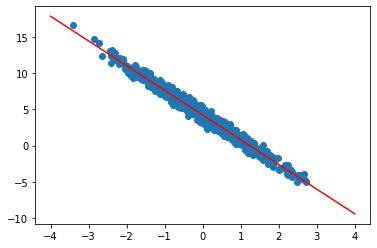

In [12]:
# compare w and b with the ground truth
print(f'The estimated w is {w.item()}, the true w is {true_w.item()};') 
print(f'The estimated b is {b.item()}, the true b is {true_b.item()}')

# plot it
plt.scatter(features, labels)
x = range(-4, 5)
y = [model(i,w,b).detach().numpy() for i in x]
plt.plot(x, y, 'r')

### Change different optimizers
In the above example, we define the `sgd()` optimizer by ourselves. However, Pytorch already offers a lot of different optimizers, see https://pytorch.org/docs/stable/optim.html#how-to-use-an-optimizer. Here, we will show how to use the `Adam` optimizer offered by Pytorch. We will show it by keeping the model the same, but change the training loop.

In [13]:
# let's first define the adam optimizer
optimizer = torch.optim.Adam([w, b], lr=learning_rate)

Again, let's first initialize the parameters. Since we already define the $w$ and $b$, we can easily modify their data by changing `w.data` and `b.data`. Notice that 

In [14]:
# Because we want to show 
w.data = torch.normal(mean=torch.tensor([0.]), std=torch.tensor([0.1]))
b.data = torch.zeros(1)

In [15]:
# training loop
for epoch in range(num_epoch):
    for x, y in data_iter(batch_size, features, labels):
        optimizer.zero_grad() # ! Remember to call zero_grad()
        y_hat = model(x, w, b)
        loss = loss_fn(y_hat, y).sum()
        
        # calculat gradient on loss w.r.t w and b
        loss.backward()
        # preform the gradient descent step to update parameters
        optimizer.step()
    
    # print
    with torch.no_grad():
        train_loss = loss_fn(model(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_loss.mean())}')

epoch 1, loss 9.069252967834473
epoch 2, loss 5.062711715698242
epoch 3, loss 2.670809507369995
epoch 4, loss 1.3396475315093994
epoch 5, loss 0.6380116939544678
epoch 6, loss 0.32141920924186707
epoch 7, loss 0.1893029361963272
epoch 8, loss 0.14160916209220886
epoch 9, loss 0.12600655853748322
epoch 10, loss 0.12143859267234802


Here, we want to stress the `optimizer.zero_grad()` function. The `backward()` function, by default, accumulates gradients in the `.grad` buffer. This means that every call to `backward` **adds the gradient** to what is currently stored in the buffer, instead of overwriting it. This is useful when dealing with large models and dataset/batch sizes, where the whole data doesn't fit into memory and the gradients have to be calculated for a larger number of samples and averaged. In our case, we want to calcualte the current gradient value at each iteration, so we have to manually zero out the gradients by calling `optimizer.zero_grad()`.


In [16]:
# compare w and b with the ground truth
print(f'The estimated w is {w.item()}, the true w is {true_w.item()};') 
print(f'The esimated b is {b.item()}, the true b is {true_b.item()}')

The estimated w is -3.384695053100586, the true w is -3.4000000953674316;
The esimated b is 4.161173343658447, the true b is 4.199999809265137


## 2. Basic Neural Network
In our assignments, we will use very basic neural networks, especially multilayer perceptrons (MLPs). "For certain choices of the activation function, it is widely known that MLPs are **universal approximators**. Even with a single-hidden-layer network, given enough nodes (possibly absurdly many), and the right set of weights, **we can model any function**, though actually learning that function is the hard part." MLPs are vastly adopted in reinforcement learning to represent the policy, the value function or the dynamic model. In this tutorial, we will quickly go through how to define MLPs and how to train it. For more detail, please check http://www.d2l.ai/chapter_multilayer-perceptrons/mlp.html

### Define the network

In [17]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

net = Net(1, 1, 10)
print(net)

Net(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


The above `Net` class defines a simple two-layer neural network. In `__init__` function, you can initialize the network, and the operations on inputs are implemented in the `forward` function. As a subclass of `nn.Module`, the backpropagation is automatically built after implementing the `forward` function. 

`nn.Linear()` is used to define the linear layer $y = w x + b$, and `F.relu()` is the activition function, defined as $relu(x) = max(x, 0)$.

### Train the network
To be concise, we will use the defined MLPs to approximate a linear model similar to our linear regression example. Please remember that the MLPs is a powerful function approximator, so they can represent much more complex models. We will use the neural network to solve a more complex task later.

In this toy example, we will use the same loss function, the same dataset as above, the only difference is instead of using the linear model, we use two-layer MLPs here.

The parameters of the MLPs are automatically initialized when defining them. The default initialized values depend on the type of layers. Specifically, for linear layers, the initialized value is given by $U(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{in\_features}$ (see https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L435-L68). 

The initialized values are:

In [18]:
for w in net.parameters():
    print(w)

Parameter containing:
tensor([[-0.1063],
        [-0.4625],
        [-0.5468],
        [ 0.1303],
        [ 0.8797],
        [-0.5968],
        [ 0.1255],
        [-0.7445],
        [-0.9135],
        [-0.0865]], requires_grad=True)
Parameter containing:
tensor([ 0.6870,  0.6928, -0.6203, -0.5075,  0.0336,  0.0019,  0.5913, -0.6671,
         0.1970,  0.1624], requires_grad=True)
Parameter containing:
tensor([[-0.0963,  0.3123,  0.1501, -0.1534,  0.3066, -0.2851,  0.1462,  0.1528,
         -0.0935,  0.1652],
        [-0.3105, -0.2966,  0.1985,  0.0468, -0.1024, -0.1075, -0.1202,  0.2795,
          0.2169, -0.2171],
        [-0.0121, -0.1958, -0.1180,  0.2977, -0.0958,  0.3156, -0.0798,  0.0919,
         -0.0384, -0.2942],
        [ 0.0118, -0.0936, -0.0148, -0.1755,  0.1892,  0.2182, -0.2960,  0.2528,
          0.1387, -0.0884],
        [-0.2091,  0.1648,  0.2598, -0.0867,  0.0978,  0.0121,  0.0657, -0.0814,
         -0.2462,  0.0156],
        [ 0.1214, -0.1721,  0.2962, -0.2099, -0.025

Now, let's train our network similar to the above example.

In [19]:
# Define the optimizer, 
num_epoch=15
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
# training loop
for epoch in range(num_epoch):
    for x, y in data_iter(batch_size, features, labels):
        optimizer.zero_grad() # ! Remember to call zero_grad()
        y_hat = net(x)
        loss = loss_fn(y_hat, y).sum()
        
        # calculat gradient on loss w.r.t w and b
        loss.backward()
        # preform the gradient descent step to update parameters
        optimizer.step()
    
    # print
    with torch.no_grad():
        net.eval()
        train_loss = loss_fn(net(features), labels)
        print(f'epoch {epoch+1}, loss {float(train_loss.mean())}')
        net.train()

epoch 1, loss 0.21708008646965027
epoch 2, loss 0.1381392478942871
epoch 3, loss 0.12913581728935242
epoch 4, loss 0.127198725938797
epoch 5, loss 0.1336274892091751
epoch 6, loss 0.12410368770360947
epoch 7, loss 0.13476374745368958
epoch 8, loss 0.12787781655788422
epoch 9, loss 0.1228647381067276
epoch 10, loss 0.13053394854068756
epoch 11, loss 0.14114776253700256
epoch 12, loss 0.2078314572572708
epoch 13, loss 0.15255621075630188
epoch 14, loss 0.124310702085495
epoch 15, loss 0.12995916604995728


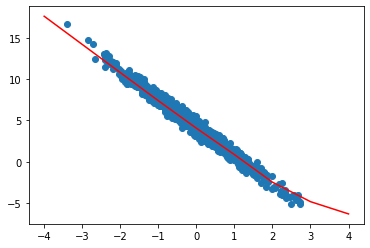

In [20]:
# plot it
plt.scatter(features, labels)
x = torch.tensor(range(-4, 5), dtype=torch.float32).unsqueeze(-1)
y = [net(i).detach().numpy() for i in x]
plt.plot(x, y, 'r')

# Part II
In this part, we will introduce an operator that you will see in your assignment -- the `detach()` operator. Please pay more attention to this operator since many silence bugs are caused by it. **The `detach()` operator will return a new Tensor, detached from the current computational graph, and the returned Tensor will never require gradient.** 


## 3. The `detach()` operator
It might be more straightforward to understand the `detach()` operator by showing how it influences the `w` parameter.

In [21]:
print(f'Before calling detach(), w is {w}')
print(f'After calling detach(), w is {w.detach()}')

Before calling detach(), w is Parameter containing:
tensor([0.1407], requires_grad=True)
After calling detach(), w is tensor([0.1407])


Obviously, by calling the `detach()` on the parameter `w`, the returned new Tensor doesn't require grad anymore, such its value won't be updated by the optimizer.

Notice that the `w.detach()` returns a new Tensor, but the original `w` is not modified, which means the `w` still requires grad. 

In [22]:
w

Parameter containing:
tensor([0.1407], requires_grad=True)

Looks simple right? Now we will show how this simple operator is used in practice by two concrete examples.

## 4. Example 1: Scaling gradients
Imagine a scenario where we have a parametrized function (for example, a neural network) $f_{\theta_1}(x)$ and we are interested in **scaling** the calculated gradients by the values of some other function $g_{\theta_2}(x)$, which **shares the first layer with network $\theta_1$**.

Without using the `detach()` operator, the parameter will be updated as: $$ \theta_1 \leftarrow \theta_1 + \alpha \nabla_{\theta} \sum_i^N g_{\theta_2}(x_i) f_{\theta_1}(x_i) $$

However, notice that this gradient is actually not what we want. We only what to **scale** the gradient $\nabla_{\theta} f_{\theta_1}(x_i) $ by the function $g_{\theta_2}(x_i)$, but here, the gradient flow will pass through the $g_{\theta_2}(x_i)$ since it shares the first layer with $f_{\theta_1}$. 

This problem can be easily fixed by using the `detach()` operator on $g_{\theta_2}$. After calling `detach()`, the $g_{\theta_2}$ doesn't require grad anymore and gradient flow won't pass through it. So we can safely wright the above formula as: 
$$ \theta_1 \leftarrow \theta_1 + \alpha  \sum_i^N g_{\theta_2}(x_i) \nabla_{\theta} f_{\theta_1}(x_i) $$

In [ ]:
# Pseudocode
f_values = f(x) # Parametrized by theta_1
g_values = g(x) # Parametrized by theta_2, but shares the first layer with theta_1
g_stopgrad = g_values.detach() # Same as g_values, but not parametrized by theta anymore

objective = torch.sum(g_stopgrad*f_values)
objective.backward()

## 5. Example 2: SimSiam Network
To better understand this `detach()` operator, let's take SimSiam (https://arxiv.org/pdf/2011.10566.pdf) architecture as an example.

SimSiam architecture is used to learn image representation via unsupervised learning such that the similar samples stay close, while dissimilar ones are far apart (contrastive learning). SimSiam, as shown in the following figure, achieves this by learning an encoder `f` such that for an image `x` with different augmentation `aug1(x)` and `aug2(x)`, we can encode them into **similar** latent representations `z1` and `z2`. 
                                                     
                                                       <---X--- stop-grad
                         ---> aug1(x)---> encoder (f) ----------------------
                        |                                                   |
            image x --- |                                               Similarity
                        |                                                   |
                         ---> aug2(x)---> encoder (f) ---> predictor (h) ---

Notice that both encoders `f` share the same parameters, if we directly maximize the similarity, the training will collapse, aka, for all images, the encoder f with always output the same z. Why? If for any input `x`, the encoder returns the same vector, say $[0, 0, 0]^T$, the similarity is always maximized, thus the optimizer will lead to this solution.

In order to get the non-collapsing solutions, we need to **change the computational graph**. How? SimSiam proposes to use the **stop-grad** operator on one encoder and only update another encoder. To achieve this, in Pytorch, we can easily call `detach()` on the encoder to remove (see the `D(p, z)` function in the pseudocode). 

The Pytorch-like pseudocode of SimSiam is:

In [ ]:
# Pseudocode
# f: encoder network, with parameters \theta
# h: prediction mlp

for x in loader: # load a minibatch x with n samples
    x1, x2 = aug_1(x), aug_2(x)  # random image augmentation
    z1, z2 = f(x1), f(x2)
    p1, p2 = h(z1), h(z2)
    
    loss = D(p1, z2)/2 + D(p2, z1)/2  # loss is the similarity between p1 and p2
    
    loss.backward()
    update(f, h)
    
def D(p, z):  # negative cosine similarity
    
    z = z.detach() # Notice here, stop grad, the key operator
    
    p = normalize(p, dim=-1) # l2 normalize
    z = normalize(x, dim=-1) # l2 normalize
    
    return - (p * z).sum(dim=-1).mean()

# Optional: Image Classification
We have shown how to use an MLP to fit a simple model on a toy example, now let's use neural networks to solve a real task -- training an image classifier. The task is relatively straightforward: we have a bunch of images, we want to distinguish which classes they belong to. This example serves as a full example to help you understand how to prepare the data, how to build the model and how to train it. 

References: 1. http://www.d2l.ai/chapter_convolutional-neural-networks/index.html  
            2. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

### Prepare Data
Like the above examples, the first thing is to prepare the dataset. Instead of generating a synthetic dataset, this time we use the CIFAR10 dataset, which is easy to download and process with the help of PyTorch. The image pre-processing includes two steps: change them to `Tensor` format and then normalize them. After loading and pre-processing the `trainset` and `testset`, in order to train the model, we typically want to pass samples in `minibatches`, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. This can be done easily using the `DataLoader` API, which wraps an iterable around the `Dataset` to enable easy access to the samples.


In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4 # training minibatch size

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


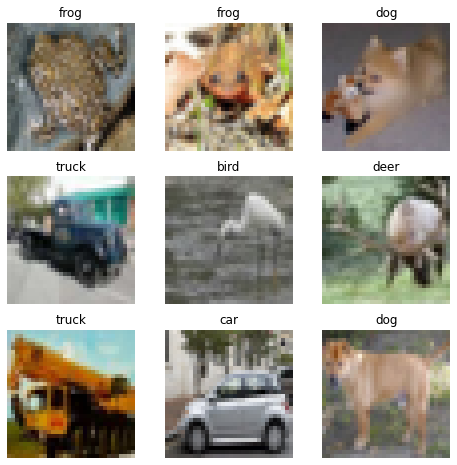

In [25]:
# let's plot some samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    # process data inorder to show them
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0)) # notice the default image is 3*32*32, we need to change them to 32*32*3

    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(npimg)
plt.show()


### Define the Convolutional Neural Network
The convolutional neural network (CNN) is designed for processing images. CNN-based architectures are now ubiquitous in the field of computer vision, and become the default choice when inputs are pixels. Here, we only introduce the simplest CNN model, for modern CNN architectures that are widely used in DL, please check http://www.d2l.ai/chapter_convolutional-modern/index.html. 

In this example, we use two convolutional layers following three fully connected layers as our model. The output is a vector with size 10 corresponding to the probability of each class. To make predictions, we choose the label with the maximal probability.

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### Train the Model
The model training procedure is followed the previous examples, thus we won't discuss more. The full example can be found in PyTorch's tutorial.

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.843
[1,  6000] loss: 1.670
[1,  8000] loss: 1.586
[1, 10000] loss: 1.509
[1, 12000] loss: 1.460
[2,  2000] loss: 1.412
[2,  4000] loss: 1.379
[2,  6000] loss: 1.367
[2,  8000] loss: 1.351
[2, 10000] loss: 1.322
[2, 12000] loss: 1.288
Finished Training


In [28]:
# save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Visualize the Results

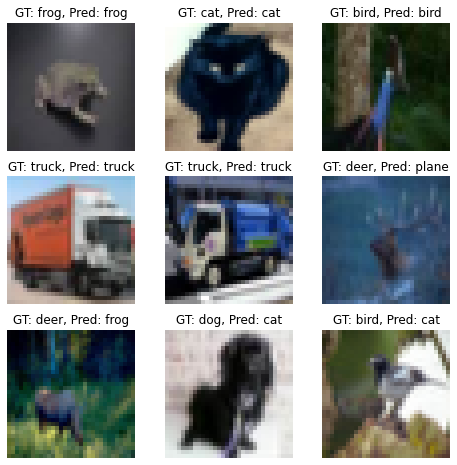

In [29]:
# let's plot some samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]

    # calculate outputs by running images through the network
    outputs = net(img.unsqueeze(dim=0))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    # process data inorder to show them
    npimg = (img/2+0.5).numpy() # unnormalize and convert to numpy
    npimg = np.transpose(npimg, (1, 2, 0)) # notice the default image is 3*32*32, we need to change them to 32*32*3
    
    figure.add_subplot(rows, cols, i)
    plt.title(f'GT: {classes[label]}, Pred: {classes[predicted]}')
    plt.axis("off")
    plt.imshow(npimg)
plt.show()

In [30]:
# let's calculate the overall test accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %
